In [2]:
%load_ext autoreload
%autoreload 2
import json
import os
import sys

import keras.backend as K
from keras.models import load_model
from keras.optimizers import Adam
import numpy as np
import tensorflow as tf

from dataset_utils import adni_loader
#from networks import transform_network_utils

sys.path.append('../neuron')
sys.path.append('../voxelmorph')
import src.losses as vm_losses

gpu_ids = [0]
# set gpu id and tf settings
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import sys
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
import tensorflow as tf
from voxelmorph import dense_3D_spatial_transformer
from keras.models import load_model
 
sys.path.append('../neuron')
import neuron.layers as nrn_layers
import neuron.utils as nrn_utils
sys.path.append('../voxelmorph-sandbox')
import voxelmorph.networks as vm_networks
from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer


fwd_model = load_model(
    './experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter20000.h5',
    custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                    'interp_upsampling': vm_networks.interp_upsampling,
                    'meshgrid': vm_networks.meshgrid,
                    'tf': tf,
                    
                    'VecInt': nrn_layers.VecInt,
                    'SpatialTransformer': nrn_layers.SpatialTransformer,
                    'nrn_utils': nrn_utils,
                    'nrn_layers': nrn_layers,
                   },
    compile=False,
)

bck_model = load_model(
    './experiments/voxelmorph/vm2_cc_AtoUMS_100k_UMStoCS_xy_iter40000.h5',
    custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
                    'interp_upsampling': vm_networks.interp_upsampling,
                    'meshgrid': vm_networks.meshgrid,
                    'tf': tf,
                    
                    'VecInt': nrn_layers.VecInt,
                    'SpatialTransformer': nrn_layers.SpatialTransformer,
                    'nrn_utils': nrn_utils,
                    'nrn_layers': nrn_layers,
                   },
    compile=False,
)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]
[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


ValueError: The name "model_2" is used 2 times in the model. All layer names should be unique.

../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


Loading adni dataset adni-unnorm-masked_100ul_subj-OASIS_OAS1_0327-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'unnormalized': True, 'masked': True, 'n_shot': 1, 'use_atlas_as_source': False, 'use_subject': 'OASIS_OAS1_0327_MR1_mri_talairach_orig', 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_vte_aug': None, 'n_flow_aug': None, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'warp_labels': True, 'n_dims': 3, 'orig_img_shape': (160, 192, 224, 1), 'scale': 1.0, 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_m

(100, 160, 192, 224, 1)
(2, 160, 192, 224, 1)
(50, 160, 192, 224, 1)
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz']
True


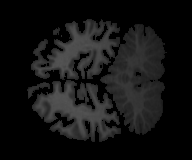

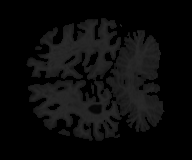

In [4]:
# create diffeomorphic model
sys.path.append('../voxelmorph')
import src.networks as vm_networks

nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 32, 16, 16]

# vm2 model
vm_new_model = vm_networks.cvpr2018_net(
    vol_size=(160, 192, 224),
    enc_nf=nf_enc, 
    dec_nf=nf_dec,
    indexing='xy'
)


[(None, 160, 192, 224, 1), (None, 160, 192, 224, 3)]


In [5]:
vm_new_model.summary()
import data_utils
import src.losses as vm_losses

# just train voxelmorph
vm_new_model.compile(
    #loss=['mean_squared_error', vm_losses.gradientLoss('l2')],
    #loss=[vm_losses.cc3D(), vm_losses.gradientLoss('l2')],
    loss=[vm_losses.NCC().loss, vm_losses.Grad('l2').loss],
          #vm_losses.gradientLoss('l2')],
    #loss_weights=[1.0, ,0.01],
    loss_weights=[1.0, 1.],#0.01],
    #loss_weights=[1., 1., 1., 0.],#0.01],
    optimizer=Adam(0.0001)
)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

In [6]:

# copy weights from regular voxelmorph as initialization
for li, l in enumerate(vm_new_model.layers):
    print(l.name)
    if l.name == voxelmorph_model.layers[li].name:
        print(l.name)
        vm_new_model.layers[li].set_weights(voxelmorph_model.layers[li].get_weights())

input_1
input_1
input_2
input_2
concatenate_1
concatenate_1
conv3d_1
conv3d_1
leaky_re_lu_1
leaky_re_lu_1
conv3d_2
conv3d_2
leaky_re_lu_2
leaky_re_lu_2
conv3d_3
conv3d_3
leaky_re_lu_3
leaky_re_lu_3
conv3d_4
conv3d_4
leaky_re_lu_4
leaky_re_lu_4
conv3d_5
conv3d_5
leaky_re_lu_5
leaky_re_lu_5
up_sampling3d_1
up_sampling3d_1
concatenate_2
concatenate_2
conv3d_6
conv3d_6
leaky_re_lu_6
leaky_re_lu_6
up_sampling3d_2
up_sampling3d_2
concatenate_3
concatenate_3
conv3d_7
conv3d_7
leaky_re_lu_7
leaky_re_lu_7
up_sampling3d_3
up_sampling3d_3
concatenate_4
concatenate_4
conv3d_8
conv3d_8
leaky_re_lu_8
leaky_re_lu_8
conv3d_9
conv3d_9
leaky_re_lu_9
leaky_re_lu_9
up_sampling3d_4
up_sampling3d_4
concatenate_5
concatenate_5
conv3d_10
conv3d_10
leaky_re_lu_10
leaky_re_lu_10
conv3d_11
conv3d_11
leaky_re_lu_11
leaky_re_lu_11
flow
flow
spatial_transformer_1
spatial_transformer_1


/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz


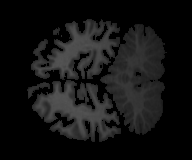

In [7]:
print(ds.files_labeled_train[0])
# source_X = ds.X_atlas
source_X, _ = adni_loader._load_vol_and_seg(ds.files_labeled_train[0], load_seg=False, mask_vol=ds.params['masked'])
source_X = source_X[np.newaxis]
IPython.display.display(PIL.Image.fromarray((source_X[0, :, :, 64, 0]*255).astype(np.uint8)))



In [ ]:
start_iter = 10000
print(start_iter)
n_train_iters = 90000
vol_gen = ds.gen_vols_batch(['labeled_train', 'unlabeled_train'], batch_size=1, randomize=True)
print(ds.files_labeled_train + ds.files_unlabeled_train)
#vol_gen = data_utils.gen_batch(X_unlabeled, X_unlabeled, batch_size=1, randomize=True)
target_X, _ = next(vol_gen)
zeros_flow = np.zeros(target_X.shape[:-1] + (3,))

for bi in range(n_train_iters + 1):
    
    target_X, _ = next(vol_gen)
    vm_losses = vm_new_model.train_on_batch([source_X, target_X], [target_X, zeros_flow])
    print('Iter {}, loss {}'.format(bi, vm_losses))
    
    if bi > 0 and bi % 2000 == 0:
        vm_new_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_100k_CStoUMS_xy_iter{}.h5'.format(start_iter + bi))

10000
['/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_263697.long.153_S_4077_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_223532.long.153_S_2109_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_76615.long.021_S_0984_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100329_NW33DK_FS_mri_talairach_orig.npz', '/data/ddmg/voxelmorph/data/t1_mix/proc/resize2

Iter 0, loss [-0.21234852, -0.25739086, 0.045042332]
Iter 1, loss [-0.21624011, -0.2545602, 0.038320087]
Iter 2, loss [-0.20601569, -0.24747671, 0.041461017]
Iter 3, loss [-0.21138331, -0.25193274, 0.04054942]
Iter 4, loss [-0.20652282, -0.25439268, 0.04786987]
Iter 5, loss [-0.2106624, -0.2544796, 0.0438172]
Iter 6, loss [-0.22022071, -0.28127357, 0.06105286]
Iter 7, loss [-0.21124049, -0.25080326, 0.03956278]
Iter 8, loss [-0.22321016, -0.29491305, 0.07170289]
Iter 9, loss [-0.20890798, -0.2563321, 0.04742412]
Iter 10, loss [-0.20539476, -0.24757071, 0.042175945]
Iter 11, loss [-0.2216606, -0.26128465, 0.03962405]
Iter 12, loss [-0.21018745, -0.26935843, 0.059170976]
Iter 13, loss [-0.21722451, -0.25247008, 0.035245564]
Iter 14, loss [-0.20843962, -0.25550202, 0.04706239]
Iter 15, loss [-0.20231612, -0.24190521, 0.03958909]
Iter 16, loss [-0.23010048, -0.28717598, 0.057075497]
Iter 17, loss [-0.20207629, -0.24315381, 0.041077524]
Iter 18, loss [-0.2398288, -0.30603513, 0.06620633]
It

Iter 154, loss [-0.22189176, -0.2601011, 0.03820934]
Iter 155, loss [-0.2258253, -0.27148715, 0.045661848]
Iter 156, loss [-0.22622812, -0.2718654, 0.045637272]
Iter 157, loss [-0.19676277, -0.24353157, 0.0467688]
Iter 158, loss [-0.20954782, -0.24691318, 0.037365355]
Iter 159, loss [-0.22323926, -0.2917369, 0.06849764]
Iter 160, loss [-0.21941909, -0.25638688, 0.036967784]
Iter 161, loss [-0.2094814, -0.24586858, 0.036387175]
Iter 162, loss [-0.20586583, -0.24677044, 0.040904604]
Iter 163, loss [-0.20563918, -0.2469995, 0.041360315]
Iter 164, loss [-0.21618742, -0.25557163, 0.039384216]
Iter 165, loss [-0.23458765, -0.29867697, 0.06408931]
Iter 166, loss [-0.21195534, -0.2579979, 0.04604256]
Iter 167, loss [-0.20424744, -0.25499606, 0.05074861]
Iter 168, loss [-0.22620496, -0.2652235, 0.039018538]
Iter 169, loss [-0.20846756, -0.24989069, 0.041423127]
Iter 170, loss [-0.22526664, -0.26415414, 0.03888751]
Iter 171, loss [-0.20506316, -0.25541043, 0.05034727]
Iter 172, loss [-0.22711346

Iter 306, loss [-0.22451597, -0.2651618, 0.04064583]
Iter 307, loss [-0.21963844, -0.2585978, 0.038959347]
Iter 308, loss [-0.21655025, -0.25476623, 0.03821598]
Iter 309, loss [-0.2090751, -0.24686255, 0.03778746]
Iter 310, loss [-0.22708994, -0.2646188, 0.037528876]
Iter 311, loss [-0.21615444, -0.25482076, 0.038666323]
Iter 312, loss [-0.21099782, -0.25563127, 0.044633444]
Iter 313, loss [-0.20994847, -0.24782132, 0.037872855]
Iter 314, loss [-0.2084174, -0.2521114, 0.043694]
Iter 315, loss [-0.21575785, -0.25652364, 0.040765796]
Iter 316, loss [-0.2124128, -0.24965662, 0.03724382]
Iter 317, loss [-0.21315771, -0.2523711, 0.039213397]
Iter 318, loss [-0.20916604, -0.24929339, 0.040127352]
Iter 319, loss [-0.20998102, -0.2496902, 0.039709173]
Iter 320, loss [-0.21740817, -0.25657204, 0.03916387]
Iter 321, loss [-0.20749915, -0.24516644, 0.037667297]
Iter 322, loss [-0.21514589, -0.25502717, 0.039881296]
Iter 323, loss [-0.21706343, -0.25569835, 0.03863492]
Iter 324, loss [-0.23561615,

Iter 458, loss [-0.18056248, -0.22848915, 0.04792666]
Iter 459, loss [-0.217662, -0.25449172, 0.03682971]
Iter 460, loss [-0.20452747, -0.24060592, 0.03607846]
Iter 461, loss [-0.21202426, -0.25133544, 0.03931118]
Iter 462, loss [-0.22659308, -0.2644666, 0.037873544]
Iter 463, loss [-0.21797699, -0.25947195, 0.041494973]
Iter 464, loss [-0.20952585, -0.24914598, 0.039620124]
Iter 465, loss [-0.21313232, -0.25541052, 0.042278208]
Iter 466, loss [-0.20703346, -0.24489668, 0.037863225]
Iter 467, loss [-0.21072318, -0.24869344, 0.037970256]
Iter 468, loss [-0.217072, -0.25511718, 0.038045183]
Iter 469, loss [-0.20623054, -0.24692732, 0.040696785]
Iter 470, loss [-0.21717422, -0.28057283, 0.063398615]
Iter 471, loss [-0.21485214, -0.25591454, 0.041062396]
Iter 472, loss [-0.22290707, -0.26802498, 0.045117907]
Iter 473, loss [-0.21008132, -0.25519568, 0.04511435]
Iter 474, loss [-0.21500975, -0.25559735, 0.04058761]
Iter 475, loss [-0.21983962, -0.25964987, 0.039810255]
Iter 476, loss [-0.22

Iter 610, loss [-0.22004583, -0.26289317, 0.042847328]
Iter 611, loss [-0.21297401, -0.24944057, 0.036466554]
Iter 612, loss [-0.20371999, -0.24670856, 0.042988565]
Iter 613, loss [-0.20393807, -0.24572876, 0.0417907]
Iter 614, loss [-0.19766103, -0.23748848, 0.039827447]
Iter 615, loss [-0.20763867, -0.2550239, 0.047385227]
Iter 616, loss [-0.20521131, -0.24582657, 0.040615268]
Iter 617, loss [-0.17471528, -0.2268558, 0.052140515]
Iter 618, loss [-0.20321442, -0.2416514, 0.038436983]
Iter 619, loss [-0.20134792, -0.24062403, 0.03927611]
Iter 620, loss [-0.21383595, -0.24804991, 0.034213968]
Iter 621, loss [-0.2084891, -0.2421215, 0.033632398]
Iter 622, loss [-0.20475513, -0.24172518, 0.03697005]
Iter 623, loss [-0.21763714, -0.2778554, 0.060218256]
Iter 624, loss [-0.21558085, -0.2575961, 0.04201525]
Iter 625, loss [-0.215676, -0.25466457, 0.03898857]
Iter 626, loss [-0.20602462, -0.24818213, 0.042157512]
Iter 627, loss [-0.21605825, -0.25739273, 0.04133448]
Iter 628, loss [-0.2077096

Iter 762, loss [-0.20880164, -0.25116944, 0.042367797]
Iter 763, loss [-0.21223065, -0.24751084, 0.03528019]
Iter 764, loss [-0.21061957, -0.24869852, 0.038078956]
Iter 765, loss [-0.21835345, -0.2572017, 0.03884826]
Iter 766, loss [-0.21145967, -0.25468695, 0.043227285]
Iter 767, loss [-0.22621618, -0.28733045, 0.061114263]
Iter 768, loss [-0.21028146, -0.2581036, 0.047822148]
Iter 769, loss [-0.21237522, -0.2523872, 0.04001197]
Iter 770, loss [-0.21752796, -0.25745082, 0.039922867]
Iter 771, loss [-0.20898956, -0.2493987, 0.04040914]
Iter 772, loss [-0.20523974, -0.25475854, 0.0495188]
Iter 773, loss [-0.22635551, -0.26522812, 0.03887261]
Iter 774, loss [-0.2264297, -0.26472685, 0.038297143]
Iter 775, loss [-0.20264313, -0.240754, 0.038110875]
Iter 776, loss [-0.30723774, -0.31668803, 0.0094503]
Iter 777, loss [-0.21786408, -0.2537218, 0.035857722]
Iter 778, loss [-0.22526512, -0.2608948, 0.035629682]
Iter 779, loss [-0.21834615, -0.2552025, 0.036856346]
Iter 780, loss [-0.20467147, 

Iter 914, loss [-0.21022013, -0.25170255, 0.04148242]
Iter 915, loss [-0.21561004, -0.25371075, 0.0381007]
Iter 916, loss [-0.20574804, -0.24768496, 0.04193692]
Iter 917, loss [-0.20603256, -0.24154156, 0.035509005]
Iter 918, loss [-0.22868292, -0.289872, 0.061189067]
Iter 919, loss [-0.17915183, -0.22979257, 0.050640732]
Iter 920, loss [-0.21626712, -0.2570934, 0.04082628]
Iter 921, loss [-0.20198542, -0.24330415, 0.041318722]
Iter 922, loss [-0.20771524, -0.24747494, 0.0397597]
Iter 923, loss [-0.2248382, -0.2645876, 0.03974942]
Iter 924, loss [-0.21679258, -0.25407422, 0.03728163]
Iter 925, loss [-0.21698967, -0.2559663, 0.038976647]
Iter 926, loss [-0.20598231, -0.24109475, 0.035112437]
Iter 927, loss [-0.21562238, -0.26009813, 0.044475745]
Iter 928, loss [-0.21836604, -0.2567298, 0.038363766]
Iter 929, loss [-0.21105954, -0.25139877, 0.04033923]
Iter 930, loss [-0.22572523, -0.26593232, 0.040207084]
Iter 931, loss [-0.20953825, -0.2580998, 0.048561536]
Iter 932, loss [-0.21337503,

Iter 1065, loss [-0.21256097, -0.25414658, 0.041585606]
Iter 1066, loss [-0.21819542, -0.2551917, 0.03699629]
Iter 1067, loss [-0.24050772, -0.27593583, 0.03542811]
Iter 1068, loss [-0.2273155, -0.2659897, 0.038674187]
Iter 1069, loss [-0.22529216, -0.26413184, 0.038839687]
Iter 1070, loss [-0.21750924, -0.26274148, 0.045232244]
Iter 1071, loss [-0.22648616, -0.26336738, 0.03688122]
Iter 1072, loss [-0.22807494, -0.26523942, 0.03716448]
Iter 1073, loss [-0.20367308, -0.24245454, 0.03878146]
Iter 1074, loss [-0.22463264, -0.268541, 0.043908373]
Iter 1075, loss [-0.22935495, -0.26843226, 0.039077308]
Iter 1076, loss [-0.22435918, -0.265003, 0.04064382]
Iter 1077, loss [-0.21018252, -0.24860515, 0.03842262]
Iter 1078, loss [-0.21053857, -0.24992935, 0.039390787]
Iter 1079, loss [-0.21061452, -0.25006437, 0.03944986]
Iter 1080, loss [-0.2157071, -0.2578914, 0.042184293]
Iter 1081, loss [-0.21108836, -0.24911323, 0.03802488]
Iter 1082, loss [-0.20757551, -0.24854717, 0.04097165]
Iter 1083, 

Iter 1214, loss [-0.22691572, -0.26561692, 0.038701214]
Iter 1215, loss [-0.21904063, -0.26021683, 0.041176196]
Iter 1216, loss [-0.22500038, -0.26340187, 0.038401484]
Iter 1217, loss [-0.20626384, -0.24640287, 0.04013903]
Iter 1218, loss [-0.2172084, -0.25453228, 0.037323877]
Iter 1219, loss [-0.20433454, -0.24415748, 0.039822936]
Iter 1220, loss [-0.2088935, -0.24489076, 0.035997268]
Iter 1221, loss [-0.21095398, -0.24861607, 0.037662096]
Iter 1222, loss [-0.21828498, -0.25847515, 0.04019017]
Iter 1223, loss [-0.20960943, -0.24834378, 0.03873435]
Iter 1224, loss [-0.22301549, -0.2633333, 0.040317796]
Iter 1225, loss [-0.21797161, -0.25644314, 0.038471535]
Iter 1226, loss [-0.24029909, -0.31367207, 0.073372975]
Iter 1227, loss [-0.3061318, -0.31589437, 0.009762563]
Iter 1228, loss [-0.22001742, -0.25878504, 0.038767617]
Iter 1229, loss [-0.20680223, -0.24222042, 0.035418186]
Iter 1230, loss [-0.20313096, -0.29316306, 0.0900321]
Iter 1231, loss [-0.21769306, -0.25531566, 0.0376226]
Ite

Iter 1363, loss [-0.21866447, -0.2596084, 0.04094392]
Iter 1364, loss [-0.21626757, -0.25655577, 0.0402882]
Iter 1365, loss [-0.23132613, -0.29975954, 0.068433404]
Iter 1366, loss [-0.22659115, -0.26460853, 0.03801738]
Iter 1367, loss [-0.2112568, -0.2542823, 0.04302549]
Iter 1368, loss [-0.21682301, -0.25474718, 0.03792417]
Iter 1369, loss [-0.21092668, -0.2447614, 0.03383472]
Iter 1370, loss [-0.20783295, -0.25415415, 0.046321195]
Iter 1371, loss [-0.21728921, -0.2536462, 0.036356986]
Iter 1372, loss [-0.22019807, -0.28307894, 0.062880866]
Iter 1373, loss [-0.2095981, -0.25087568, 0.041277587]
Iter 1374, loss [-0.21277022, -0.25392482, 0.041154593]
Iter 1375, loss [-0.21852492, -0.25996166, 0.041436747]
Iter 1376, loss [-0.21753435, -0.25470173, 0.037167385]
Iter 1377, loss [-0.21541324, -0.25718802, 0.041774772]
Iter 1378, loss [-0.2150802, -0.25640428, 0.04132408]
Iter 1379, loss [-0.21775085, -0.2985691, 0.08081826]
Iter 1380, loss [-0.20363863, -0.2443686, 0.040729966]
Iter 1381,

Iter 1512, loss [-0.2116301, -0.25214344, 0.040513333]
Iter 1513, loss [-0.21769553, -0.2577685, 0.040072978]
Iter 1514, loss [-0.21153037, -0.2515084, 0.03997804]
Iter 1515, loss [-0.19880798, -0.23533314, 0.036525153]
Iter 1516, loss [-0.21611753, -0.25506756, 0.03895003]
Iter 1517, loss [-0.22246243, -0.26156303, 0.0391006]
Iter 1518, loss [-0.21756709, -0.2573982, 0.039831102]
Iter 1519, loss [-0.21470875, -0.25554916, 0.04084041]
Iter 1520, loss [-0.21474317, -0.2554429, 0.040699728]
Iter 1521, loss [-0.22501849, -0.2632013, 0.03818281]
Iter 1522, loss [-0.20900705, -0.24914965, 0.040142603]
Iter 1523, loss [-0.22390282, -0.264287, 0.040384173]
Iter 1524, loss [-0.21672988, -0.26100057, 0.0442707]
Iter 1525, loss [-0.21839248, -0.25440443, 0.03601195]
Iter 1526, loss [-0.20464194, -0.24448691, 0.039844975]
Iter 1527, loss [-0.2126807, -0.25482106, 0.042140357]
Iter 1528, loss [-0.22749162, -0.26650906, 0.039017446]
Iter 1529, loss [-0.21559091, -0.25882939, 0.043238476]
Iter 1530,

Iter 1662, loss [-0.21081981, -0.25100145, 0.040181633]
Iter 1663, loss [-0.21431758, -0.27741683, 0.06309925]
Iter 1664, loss [-0.20936747, -0.25616384, 0.046796363]
Iter 1665, loss [-0.20670031, -0.24786586, 0.04116554]
Iter 1666, loss [-0.20932302, -0.28864685, 0.079323836]
Iter 1667, loss [-0.21251033, -0.2529057, 0.04039536]
Iter 1668, loss [-0.20293155, -0.24078135, 0.037849795]
Iter 1669, loss [-0.20889631, -0.25031725, 0.041420937]
Iter 1670, loss [-0.21672831, -0.25893414, 0.042205825]
Iter 1671, loss [-0.2099503, -0.24859841, 0.03864811]
Iter 1672, loss [-0.21444164, -0.25742945, 0.04298781]
Iter 1673, loss [-0.22306201, -0.26401913, 0.04095713]
Iter 1674, loss [-0.20665753, -0.24433948, 0.03768195]
Iter 1675, loss [-0.20193446, -0.24179193, 0.03985747]
Iter 1676, loss [-0.1916981, -0.2881486, 0.0964505]
Iter 1677, loss [-0.21753046, -0.30010286, 0.08257239]
Iter 1678, loss [-0.22484791, -0.26818544, 0.043337524]
Iter 1679, loss [-0.22326377, -0.26208115, 0.038817383]
Iter 16

Iter 1811, loss [-0.23112367, -0.2668583, 0.035734635]
Iter 1812, loss [-0.21606657, -0.25680354, 0.04073697]
Iter 1813, loss [-0.21970545, -0.2590665, 0.039361045]
Iter 1814, loss [-0.21245733, -0.25463808, 0.042180754]
Iter 1815, loss [-0.21711116, -0.257434, 0.04032286]
Iter 1816, loss [-0.2105295, -0.25145444, 0.040924937]
Iter 1817, loss [-0.20803782, -0.24543235, 0.037394524]
Iter 1818, loss [-0.22317874, -0.2621547, 0.038975947]
Iter 1819, loss [-0.20488815, -0.24551183, 0.040623676]
Iter 1820, loss [-0.22007363, -0.25853375, 0.038460117]
Iter 1821, loss [-0.30721357, -0.31678802, 0.009574441]
Iter 1822, loss [-0.19625455, -0.2841594, 0.08790484]
Iter 1823, loss [-0.21518427, -0.25417164, 0.03898737]
Iter 1824, loss [-0.22232194, -0.25969547, 0.037373528]
Iter 1825, loss [-0.20298186, -0.29638883, 0.09340697]
Iter 1826, loss [-0.22568923, -0.2640594, 0.038370162]
Iter 1827, loss [-0.23869544, -0.3104258, 0.071730345]
Iter 1828, loss [-0.22535825, -0.28436014, 0.059001893]
Iter 1

Iter 1960, loss [-0.20581892, -0.25414863, 0.048329707]
Iter 1961, loss [-0.2125935, -0.24926426, 0.036670767]
Iter 1962, loss [-0.21557854, -0.2555371, 0.03995855]
Iter 1963, loss [-0.24471891, -0.30779734, 0.06307843]
Iter 1964, loss [-0.22173162, -0.2589437, 0.037212085]
Iter 1965, loss [-0.22417793, -0.26143444, 0.0372565]
Iter 1966, loss [-0.24069068, -0.27542004, 0.034729365]
Iter 1967, loss [-0.21615985, -0.25567868, 0.03951884]
Iter 1968, loss [-0.20761415, -0.24624363, 0.038629472]
Iter 1969, loss [-0.2179143, -0.25548515, 0.037570845]
Iter 1970, loss [-0.22896026, -0.30094558, 0.07198532]
Iter 1971, loss [-0.21596348, -0.25675532, 0.040791847]
Iter 1972, loss [-0.21999013, -0.26028553, 0.04029539]
Iter 1973, loss [-0.210348, -0.25805387, 0.04770587]
Iter 1974, loss [-0.21494985, -0.2526335, 0.037683662]
Iter 1975, loss [-0.23836061, -0.2967576, 0.058396995]
Iter 1976, loss [-0.20202161, -0.24057308, 0.038551465]
Iter 1977, loss [-0.21081269, -0.24939013, 0.038577445]
Iter 197

Iter 2109, loss [-0.20910853, -0.24973148, 0.04062295]
Iter 2110, loss [-0.22049753, -0.26190457, 0.041407038]
Iter 2111, loss [-0.206563, -0.25019082, 0.04362782]
Iter 2112, loss [-0.21059534, -0.25155804, 0.04096269]
Iter 2113, loss [-0.21794158, -0.2561527, 0.038211107]
Iter 2114, loss [-0.21836069, -0.2574242, 0.039063513]
Iter 2115, loss [-0.2118315, -0.25036854, 0.038537037]
Iter 2116, loss [-0.2240262, -0.2605054, 0.0364792]
Iter 2117, loss [-0.2057642, -0.24298674, 0.03722253]
Iter 2118, loss [-0.21604243, -0.25602722, 0.039984792]
Iter 2119, loss [-0.22820029, -0.29912403, 0.07092375]
Iter 2120, loss [-0.30676144, -0.3165137, 0.009752257]
Iter 2121, loss [-0.21534473, -0.2583514, 0.04300665]
Iter 2122, loss [-0.2206795, -0.25970647, 0.03902696]
Iter 2123, loss [-0.21268699, -0.2526397, 0.039952733]
Iter 2124, loss [-0.30802473, -0.3172264, 0.009201679]
Iter 2125, loss [-0.21282287, -0.24731523, 0.03449236]
Iter 2126, loss [-0.18047675, -0.22741498, 0.046938233]
Iter 2127, loss

Iter 2258, loss [-0.2147837, -0.25388423, 0.03910052]
Iter 2259, loss [-0.21434057, -0.2527263, 0.03838572]
Iter 2260, loss [-0.2159645, -0.2552975, 0.03933301]
Iter 2261, loss [-0.2260947, -0.2858862, 0.059791505]
Iter 2262, loss [-0.21195315, -0.25086975, 0.0389166]
Iter 2263, loss [-0.21760547, -0.25576806, 0.03816259]
Iter 2264, loss [-0.21584943, -0.25501677, 0.039167345]
Iter 2265, loss [-0.2408995, -0.27578092, 0.03488141]
Iter 2266, loss [-0.21562119, -0.25727198, 0.04165079]
Iter 2267, loss [-0.21603926, -0.257986, 0.04194675]
Iter 2268, loss [-0.23164614, -0.26899648, 0.037350345]
Iter 2269, loss [-0.21829204, -0.25995043, 0.04165839]
Iter 2270, loss [-0.21073446, -0.25045228, 0.03971783]
Iter 2271, loss [-0.22761309, -0.2668306, 0.03921751]
Iter 2272, loss [-0.21075189, -0.2594691, 0.04871721]
Iter 2273, loss [-0.21830481, -0.2614556, 0.043150775]
Iter 2274, loss [-0.23061141, -0.29812613, 0.06751471]
Iter 2275, loss [-0.19808704, -0.24430385, 0.046216823]
Iter 2276, loss [-

Iter 2407, loss [-0.2169809, -0.26341334, 0.046432428]
Iter 2408, loss [-0.20661023, -0.24762903, 0.04101879]
Iter 2409, loss [-0.23061019, -0.2665596, 0.0359494]
Iter 2410, loss [-0.1800035, -0.22632265, 0.046319157]
Iter 2411, loss [-0.20467077, -0.23898226, 0.03431149]
Iter 2412, loss [-0.2245276, -0.26147848, 0.03695088]
Iter 2413, loss [-0.20669325, -0.24754325, 0.04085]
Iter 2414, loss [-0.19902053, -0.23561247, 0.036591925]
Iter 2415, loss [-0.21413788, -0.25470474, 0.040566854]
Iter 2416, loss [-0.22036022, -0.29687268, 0.07651246]
Iter 2417, loss [-0.2045956, -0.24556647, 0.04097087]
Iter 2418, loss [-0.21805437, -0.26070452, 0.04265015]
Iter 2419, loss [-0.21829951, -0.2531542, 0.034854677]
Iter 2420, loss [-0.21745476, -0.25529706, 0.03784231]
Iter 2421, loss [-0.2120535, -0.24648078, 0.034427285]
Iter 2422, loss [-0.23949483, -0.27254358, 0.03304875]
Iter 2423, loss [-0.21720603, -0.25568765, 0.03848163]
Iter 2424, loss [-0.30734178, -0.3169019, 0.009560096]
Iter 2425, loss

Iter 2556, loss [-0.23527287, -0.3067636, 0.07149072]
Iter 2557, loss [-0.21048558, -0.24937738, 0.038891803]
Iter 2558, loss [-0.22057115, -0.26736167, 0.04679052]
Iter 2559, loss [-0.24594443, -0.31174672, 0.06580229]
Iter 2560, loss [-0.21432647, -0.25426954, 0.039943065]
Iter 2561, loss [-0.2151711, -0.25527602, 0.04010492]
Iter 2562, loss [-0.22281761, -0.26163858, 0.038820967]
Iter 2563, loss [-0.20869662, -0.25680956, 0.048112944]
Iter 2564, loss [-0.2277551, -0.26450694, 0.036751833]
Iter 2565, loss [-0.21416116, -0.2738187, 0.059657536]
Iter 2566, loss [-0.3075705, -0.31700233, 0.009431839]
Iter 2567, loss [-0.22423838, -0.26297557, 0.038737193]
Iter 2568, loss [-0.21812312, -0.25724488, 0.039121766]
Iter 2569, loss [-0.22433296, -0.2675321, 0.043199148]
Iter 2570, loss [-0.24033763, -0.27546623, 0.035128605]
Iter 2571, loss [-0.22882281, -0.29598534, 0.06716253]
Iter 2572, loss [-0.20990571, -0.26023477, 0.050329052]
Iter 2573, loss [-0.2234029, -0.263531, 0.0401281]
Iter 257

Iter 2705, loss [-0.21884023, -0.25948486, 0.04064463]
Iter 2706, loss [-0.20735455, -0.2489711, 0.041616555]
Iter 2707, loss [-0.2202617, -0.26115587, 0.04089418]
Iter 2708, loss [-0.20414491, -0.24336353, 0.039218616]
Iter 2709, loss [-0.21638846, -0.25584674, 0.039458275]
Iter 2710, loss [-0.22446443, -0.26875278, 0.04428835]
Iter 2711, loss [-0.22855045, -0.26546425, 0.036913797]
Iter 2712, loss [-0.22316572, -0.30518717, 0.082021445]
Iter 2713, loss [-0.22532675, -0.26456195, 0.039235197]
Iter 2714, loss [-0.20519182, -0.2525185, 0.04732668]
Iter 2715, loss [-0.21840906, -0.2576665, 0.039257437]
Iter 2716, loss [-0.22116446, -0.25722668, 0.036062207]
Iter 2717, loss [-0.20305431, -0.24545746, 0.04240314]
Iter 2718, loss [-0.22527662, -0.26752162, 0.042245008]
Iter 2719, loss [-0.24103437, -0.27654627, 0.035511896]
Iter 2720, loss [-0.19776732, -0.2457064, 0.047939073]
Iter 2721, loss [-0.21067539, -0.25033665, 0.039661255]
Iter 2722, loss [-0.22422817, -0.26317137, 0.0389432]
Iter

Iter 2854, loss [-0.2220477, -0.26075616, 0.038708467]
Iter 2855, loss [-0.19746183, -0.24489997, 0.047438145]
Iter 2856, loss [-0.17999205, -0.22923562, 0.049243577]
Iter 2857, loss [-0.30607536, -0.315831, 0.009755643]
Iter 2858, loss [-0.21800132, -0.2579987, 0.03999738]
Iter 2859, loss [-0.21108407, -0.254804, 0.043719914]
Iter 2860, loss [-0.20989285, -0.24739031, 0.03749746]
Iter 2861, loss [-0.21826284, -0.25425294, 0.035990104]
Iter 2862, loss [-0.20697957, -0.24739641, 0.04041683]
Iter 2863, loss [-0.21195142, -0.2556789, 0.04372747]
Iter 2864, loss [-0.20945671, -0.25805494, 0.048598237]
Iter 2865, loss [-0.20526385, -0.24281271, 0.037548862]
Iter 2866, loss [-0.22810364, -0.2709444, 0.04284075]
Iter 2867, loss [-0.2094109, -0.2495535, 0.040142603]
Iter 2868, loss [-0.23084456, -0.26769394, 0.036849376]
Iter 2869, loss [-0.2164245, -0.25801158, 0.041587085]
Iter 2870, loss [-0.30681905, -0.31625435, 0.00943531]
Iter 2871, loss [-0.22263847, -0.2862361, 0.063597634]
Iter 2872,

Iter 3003, loss [-0.20800935, -0.25114122, 0.043131873]
Iter 3004, loss [-0.21724956, -0.25705197, 0.039802413]
Iter 3005, loss [-0.2122637, -0.25761136, 0.045347653]
Iter 3006, loss [-0.22809821, -0.26681945, 0.038721226]
Iter 3007, loss [-0.21344806, -0.25481197, 0.041363906]
Iter 3008, loss [-0.22056817, -0.26541588, 0.044847712]
Iter 3009, loss [-0.21980765, -0.25798106, 0.038173415]
Iter 3010, loss [-0.22265314, -0.25990182, 0.037248686]
Iter 3011, loss [-0.22458443, -0.2668158, 0.042231373]
Iter 3012, loss [-0.21545503, -0.25580972, 0.0403547]
Iter 3013, loss [-0.21301755, -0.25321466, 0.040197104]
Iter 3014, loss [-0.22007763, -0.26059997, 0.040522337]
Iter 3015, loss [-0.23793449, -0.3101826, 0.072248116]
Iter 3016, loss [-0.21006836, -0.24698797, 0.036919605]
Iter 3017, loss [-0.20479713, -0.24287081, 0.03807367]
Iter 3018, loss [-0.20803241, -0.24513052, 0.03709811]
Iter 3019, loss [-0.2432025, -0.30568805, 0.06248556]
Iter 3020, loss [-0.21787645, -0.25755438, 0.03967793]
It

Iter 3152, loss [-0.2059557, -0.25323182, 0.04727612]
Iter 3153, loss [-0.22613087, -0.26541674, 0.03928586]
Iter 3154, loss [-0.21180123, -0.24856976, 0.03676852]
Iter 3155, loss [-0.20998663, -0.25261456, 0.04262793]
Iter 3156, loss [-0.21617518, -0.25601256, 0.039837375]
Iter 3157, loss [-0.22960299, -0.27287647, 0.04327347]
Iter 3158, loss [-0.21089317, -0.25884855, 0.047955375]
Iter 3159, loss [-0.20789477, -0.2497396, 0.041844822]
Iter 3160, loss [-0.21129657, -0.24933931, 0.038042735]
Iter 3161, loss [-0.227339, -0.26565436, 0.03831535]
Iter 3162, loss [-0.22639243, -0.2635252, 0.03713275]
Iter 3163, loss [-0.20609924, -0.2435563, 0.037457056]
Iter 3164, loss [-0.22502834, -0.26556394, 0.0405356]
Iter 3165, loss [-0.20350803, -0.2948583, 0.09135027]
Iter 3166, loss [-0.21896182, -0.2580441, 0.039082274]
Iter 3167, loss [-0.20884553, -0.2523844, 0.043538865]
Iter 3168, loss [-0.30745438, -0.31703034, 0.009575977]
Iter 3169, loss [-0.20785436, -0.24469756, 0.036843203]
Iter 3170, 

Iter 3301, loss [-0.2249967, -0.26454842, 0.039551716]
Iter 3302, loss [-0.22568575, -0.26513276, 0.039447002]
Iter 3303, loss [-0.20603883, -0.24367571, 0.03763687]
Iter 3304, loss [-0.22834201, -0.26591918, 0.037577163]
Iter 3305, loss [-0.20753822, -0.24911425, 0.041576028]
Iter 3306, loss [-0.20650181, -0.24336682, 0.036865003]
Iter 3307, loss [-0.22622198, -0.26658148, 0.04035949]
Iter 3308, loss [-0.21379405, -0.24982905, 0.036035]
Iter 3309, loss [-0.22436804, -0.26232746, 0.037959434]
Iter 3310, loss [-0.242054, -0.3047736, 0.0627196]
Iter 3311, loss [-0.23731637, -0.30952394, 0.07220757]
Iter 3312, loss [-0.21430263, -0.27524182, 0.060939193]
Iter 3313, loss [-0.2100381, -0.24995801, 0.039919913]
Iter 3314, loss [-0.24383096, -0.290229, 0.046398025]
Iter 3315, loss [-0.21686754, -0.25907773, 0.042210184]
Iter 3316, loss [-0.21690294, -0.25722152, 0.040318586]
Iter 3317, loss [-0.20386489, -0.2523864, 0.048521504]
Iter 3318, loss [-0.20731711, -0.2500573, 0.04274019]
Iter 3319,

Iter 3451, loss [-0.30792782, -0.31732696, 0.009399156]
Iter 3452, loss [-0.22444844, -0.26143828, 0.03698984]
Iter 3453, loss [-0.21639475, -0.25768462, 0.04128987]
Iter 3454, loss [-0.22013827, -0.26032045, 0.04018219]
Iter 3455, loss [-0.20322996, -0.24224703, 0.039017074]
Iter 3456, loss [-0.22988099, -0.26831648, 0.038435493]
Iter 3457, loss [-0.21914276, -0.25774676, 0.038603988]
Iter 3458, loss [-0.22519945, -0.3055248, 0.08032535]
Iter 3459, loss [-0.21202984, -0.25344568, 0.041415833]
Iter 3460, loss [-0.21659312, -0.2564133, 0.03982019]
Iter 3461, loss [-0.19976953, -0.23614734, 0.03637781]
Iter 3462, loss [-0.21203534, -0.25263822, 0.040602878]
Iter 3463, loss [-0.22048406, -0.25895357, 0.038469505]
Iter 3464, loss [-0.22036976, -0.26076594, 0.040396176]
Iter 3465, loss [-0.21787642, -0.2565115, 0.038635086]
Iter 3466, loss [-0.2084654, -0.24488646, 0.036421068]
Iter 3467, loss [-0.22398634, -0.28501445, 0.061028108]
Iter 3468, loss [-0.21788602, -0.25847545, 0.040589433]
It

Iter 3601, loss [-0.2232337, -0.26292908, 0.03969539]
Iter 3602, loss [-0.21894309, -0.26078045, 0.041837372]
Iter 3603, loss [-0.2067746, -0.24971671, 0.042942107]
Iter 3604, loss [-0.218176, -0.25506774, 0.03689173]
Iter 3605, loss [-0.20942324, -0.25328866, 0.043865405]
Iter 3606, loss [-0.21077648, -0.25067854, 0.03990207]
Iter 3607, loss [-0.2111828, -0.24801926, 0.036836468]
Iter 3608, loss [-0.20761736, -0.24330446, 0.035687108]
Iter 3609, loss [-0.2208484, -0.2597411, 0.0388927]
Iter 3610, loss [-0.20508002, -0.25447816, 0.049398135]
Iter 3611, loss [-0.24731988, -0.31122297, 0.06390309]
Iter 3612, loss [-0.20213816, -0.24207763, 0.039939474]
Iter 3613, loss [-0.18099916, -0.23092875, 0.04992958]
Iter 3614, loss [-0.21875584, -0.25490248, 0.036146645]
Iter 3615, loss [-0.21622622, -0.25526193, 0.039035715]
Iter 3616, loss [-0.20730537, -0.24715097, 0.0398456]
Iter 3617, loss [-0.22673798, -0.26442438, 0.0376864]
Iter 3618, loss [-0.21692464, -0.25744602, 0.040521376]
Iter 3619,

Iter 3750, loss [-0.30656347, -0.3158689, 0.00930544]
Iter 3751, loss [-0.22474536, -0.2630024, 0.038257025]
Iter 3752, loss [-0.19662353, -0.24118929, 0.044565745]
Iter 3753, loss [-0.18026242, -0.22716025, 0.046897825]
Iter 3754, loss [-0.20931956, -0.24469598, 0.035376407]
Iter 3755, loss [-0.2235086, -0.28403166, 0.06052306]
Iter 3756, loss [-0.21548846, -0.2545439, 0.039055444]
Iter 3757, loss [-0.24411294, -0.30824298, 0.06413004]
Iter 3758, loss [-0.21507154, -0.25489354, 0.039821994]
Iter 3759, loss [-0.20710371, -0.245166, 0.03806229]
Iter 3760, loss [-0.21785754, -0.2566175, 0.03875994]
Iter 3761, loss [-0.24232644, -0.30456835, 0.06224191]
Iter 3762, loss [-0.21024714, -0.25034687, 0.040099725]
Iter 3763, loss [-0.23747544, -0.3165814, 0.07910596]
Iter 3764, loss [-0.21644132, -0.2578175, 0.04137619]
Iter 3765, loss [-0.20412655, -0.24794395, 0.0438174]
Iter 3766, loss [-0.20599979, -0.2485681, 0.042568304]
Iter 3767, loss [-0.21147954, -0.2540177, 0.04253816]
Iter 3768, los

Iter 3899, loss [-0.22427925, -0.26493436, 0.040655106]
Iter 3900, loss [-0.23137498, -0.26780164, 0.03642666]
Iter 3901, loss [-0.2072956, -0.24794255, 0.040646948]
Iter 3902, loss [-0.20311987, -0.24120367, 0.03808379]
Iter 3903, loss [-0.21733692, -0.25405905, 0.03672212]
Iter 3904, loss [-0.21874508, -0.25541028, 0.036665194]
Iter 3905, loss [-0.21897972, -0.25544363, 0.036463913]
Iter 3906, loss [-0.21024549, -0.2478211, 0.037575595]
Iter 3907, loss [-0.21654314, -0.2571957, 0.04065257]
Iter 3908, loss [-0.22556922, -0.2685573, 0.04298809]
Iter 3909, loss [-0.24029046, -0.31331983, 0.07302937]
Iter 3910, loss [-0.21224502, -0.25630218, 0.044057157]
Iter 3911, loss [-0.21886927, -0.25665832, 0.037789047]
Iter 3912, loss [-0.22041838, -0.25885627, 0.038437888]
Iter 3913, loss [-0.21611822, -0.25531307, 0.03919486]
Iter 3914, loss [-0.2202784, -0.2604744, 0.040196016]
Iter 3915, loss [-0.22448176, -0.30337244, 0.078890674]
Iter 3916, loss [-0.21534128, -0.25550127, 0.040159985]
Iter 

Iter 4048, loss [-0.21743752, -0.2593578, 0.04192029]
Iter 4049, loss [-0.21541053, -0.25189057, 0.036480047]
Iter 4050, loss [-0.22521375, -0.2689324, 0.043718647]
Iter 4051, loss [-0.20276058, -0.2491175, 0.046356916]
Iter 4052, loss [-0.21649115, -0.2540305, 0.037539344]
Iter 4053, loss [-0.23052448, -0.26749912, 0.036974635]
Iter 4054, loss [-0.20485246, -0.24741802, 0.04256556]
Iter 4055, loss [-0.20805463, -0.25079083, 0.0427362]
Iter 4056, loss [-0.21290039, -0.2573315, 0.0444311]
Iter 4057, loss [-0.21492928, -0.27717918, 0.062249906]
Iter 4058, loss [-0.2190294, -0.2609881, 0.04195869]
Iter 4059, loss [-0.23396939, -0.2953719, 0.061402492]
Iter 4060, loss [-0.2129219, -0.25130528, 0.038383376]
Iter 4061, loss [-0.20707723, -0.24862042, 0.041543182]
Iter 4062, loss [-0.20336339, -0.24597237, 0.042608973]
Iter 4063, loss [-0.1936413, -0.24118108, 0.04753977]
Iter 4064, loss [-0.20376453, -0.24579182, 0.042027302]
Iter 4065, loss [-0.2092289, -0.2513014, 0.042072512]
Iter 4066, l

Iter 4197, loss [-0.24581298, -0.31086054, 0.065047555]
Iter 4198, loss [-0.22515056, -0.26348418, 0.038333632]
Iter 4199, loss [-0.22512947, -0.2626446, 0.037515115]
Iter 4200, loss [-0.219017, -0.2559453, 0.036928296]
Iter 4201, loss [-0.2026515, -0.24489982, 0.042248316]
Iter 4202, loss [-0.21191478, -0.25067177, 0.038756993]
Iter 4203, loss [-0.20978162, -0.25787774, 0.04809612]
Iter 4204, loss [-0.2057598, -0.25492436, 0.049164563]
Iter 4205, loss [-0.21585989, -0.2580076, 0.04214769]
Iter 4206, loss [-0.19999191, -0.23749939, 0.03750747]
Iter 4207, loss [-0.2150478, -0.25536883, 0.04032102]
Iter 4208, loss [-0.21635243, -0.25700516, 0.040652722]
Iter 4209, loss [-0.22529185, -0.2638255, 0.038533665]
Iter 4210, loss [-0.21425267, -0.25497368, 0.040721014]
Iter 4211, loss [-0.21026967, -0.24767803, 0.037408352]
Iter 4212, loss [-0.21123701, -0.25055456, 0.039317556]
Iter 4213, loss [-0.21368533, -0.25578332, 0.042097986]
Iter 4214, loss [-0.2265972, -0.2647281, 0.038130894]
Iter 42

Iter 4346, loss [-0.21617784, -0.26068115, 0.044503313]
Iter 4347, loss [-0.20918074, -0.25227162, 0.04309088]
Iter 4348, loss [-0.22611919, -0.26593173, 0.039812528]
Iter 4349, loss [-0.20750013, -0.24517496, 0.037674837]
Iter 4350, loss [-0.21719028, -0.25327522, 0.036084935]
Iter 4351, loss [-0.20202324, -0.23919335, 0.037170116]
Iter 4352, loss [-0.23956366, -0.27290407, 0.03334041]
Iter 4353, loss [-0.21538627, -0.253918, 0.038531728]
Iter 4354, loss [-0.22811177, -0.27205023, 0.043938465]
Iter 4355, loss [-0.22279237, -0.2691509, 0.04635854]
Iter 4356, loss [-0.21798423, -0.25689977, 0.038915552]
Iter 4357, loss [-0.22283536, -0.26229838, 0.039463013]
Iter 4358, loss [-0.21837232, -0.2571118, 0.038739473]
Iter 4359, loss [-0.22023556, -0.2611393, 0.040903755]
Iter 4360, loss [-0.21526904, -0.25891584, 0.043646798]
Iter 4361, loss [-0.22881384, -0.26506662, 0.036252778]
Iter 4362, loss [-0.21834959, -0.2570015, 0.038651895]
Iter 4363, loss [-0.21000886, -0.25705594, 0.04704708]
It

Iter 4495, loss [-0.20614344, -0.24253027, 0.036386825]
Iter 4496, loss [-0.20856994, -0.24522002, 0.03665007]
Iter 4497, loss [-0.2227659, -0.26849827, 0.045732386]
Iter 4498, loss [-0.20766097, -0.2493009, 0.04163992]
Iter 4499, loss [-0.20874158, -0.24546856, 0.036726985]
Iter 4500, loss [-0.20974904, -0.30075288, 0.09100383]
Iter 4501, loss [-0.30733818, -0.3167781, 0.009439912]
Iter 4502, loss [-0.2245461, -0.2622127, 0.03766659]
Iter 4503, loss [-0.2161591, -0.25636587, 0.040206764]
Iter 4504, loss [-0.20563495, -0.2550155, 0.04938054]
Iter 4505, loss [-0.21345198, -0.25545225, 0.042000264]
Iter 4506, loss [-0.21798372, -0.26293144, 0.044947706]
Iter 4507, loss [-0.21924178, -0.25558776, 0.036345974]
Iter 4508, loss [-0.23178473, -0.26807633, 0.036291607]
Iter 4509, loss [-0.2170749, -0.2570271, 0.03995218]
Iter 4510, loss [-0.24149126, -0.27617615, 0.03468489]
Iter 4511, loss [-0.30814117, -0.31748644, 0.00934527]
Iter 4512, loss [-0.20750932, -0.24775706, 0.04024774]
Iter 4513,

Iter 4644, loss [-0.20641679, -0.24500054, 0.038583748]
Iter 4645, loss [-0.21899956, -0.25910512, 0.040105544]
Iter 4646, loss [-0.22524202, -0.27006075, 0.04481872]
Iter 4647, loss [-0.22110209, -0.26025927, 0.039157182]
Iter 4648, loss [-0.22098833, -0.26029426, 0.039305925]
Iter 4649, loss [-0.2220982, -0.25789472, 0.03579652]
Iter 4650, loss [-0.2210386, -0.26072276, 0.03968416]
Iter 4651, loss [-0.21254326, -0.25581643, 0.043273166]
Iter 4652, loss [-0.2115685, -0.27117267, 0.05960416]
Iter 4653, loss [-0.22434077, -0.26284695, 0.03850618]
Iter 4654, loss [-0.20609869, -0.25573465, 0.04963596]
Iter 4655, loss [-0.21385625, -0.2553405, 0.04148423]
Iter 4656, loss [-0.2082631, -0.24588487, 0.037621774]
Iter 4657, loss [-0.21474288, -0.29944426, 0.084701374]
Iter 4658, loss [-0.21824804, -0.25756943, 0.03932139]
Iter 4659, loss [-0.21470912, -0.25155297, 0.03684385]
Iter 4660, loss [-0.2189693, -0.25735062, 0.038381323]
Iter 4661, loss [-0.19849192, -0.23382533, 0.03533341]
Iter 466

Iter 4793, loss [-0.22861826, -0.28985515, 0.06123689]
Iter 4794, loss [-0.21363294, -0.2535925, 0.039959557]
Iter 4795, loss [-0.24398658, -0.31625897, 0.07227239]
Iter 4796, loss [-0.21471551, -0.2563758, 0.04166028]
Iter 4797, loss [-0.21341944, -0.2500962, 0.036676772]
Iter 4798, loss [-0.20395723, -0.24327965, 0.039322414]
Iter 4799, loss [-0.23124683, -0.3014352, 0.07018837]
Iter 4800, loss [-0.24907693, -0.29232362, 0.04324668]
Iter 4801, loss [-0.24347408, -0.3146209, 0.07114683]
Iter 4802, loss [-0.22111556, -0.25989214, 0.038776573]
Iter 4803, loss [-0.19872707, -0.24549931, 0.04677225]
Iter 4804, loss [-0.22823265, -0.27343404, 0.0452014]
Iter 4805, loss [-0.23648264, -0.2913378, 0.054855153]
Iter 4806, loss [-0.22817427, -0.27305594, 0.04488167]
Iter 4807, loss [-0.22061843, -0.25969204, 0.039073624]
Iter 4808, loss [-0.21685377, -0.2570865, 0.040232725]
Iter 4809, loss [-0.2229776, -0.2692088, 0.04623119]
Iter 4810, loss [-0.2113952, -0.2497121, 0.038316898]
Iter 4811, los

Iter 4942, loss [-0.20863649, -0.24961747, 0.040980987]
Iter 4943, loss [-0.20527974, -0.2472945, 0.04201477]
Iter 4944, loss [-0.2157315, -0.2520814, 0.0363499]
Iter 4945, loss [-0.23758586, -0.31285238, 0.075266525]
Iter 4946, loss [-0.211396, -0.24896367, 0.037567675]
Iter 4947, loss [-0.2180755, -0.25824067, 0.040165167]
Iter 4948, loss [-0.23841256, -0.3110684, 0.07265582]
Iter 4949, loss [-0.21011913, -0.25027525, 0.04015612]
Iter 4950, loss [-0.20439652, -0.25421652, 0.049820006]
Iter 4951, loss [-0.22660099, -0.26600343, 0.03940244]
Iter 4952, loss [-0.20747706, -0.24650298, 0.03902591]
Iter 4953, loss [-0.21725711, -0.2574245, 0.04016739]
Iter 4954, loss [-0.23833892, -0.31918186, 0.08084294]
Iter 4955, loss [-0.20337701, -0.2427573, 0.039380293]
Iter 4956, loss [-0.22859848, -0.27126458, 0.0426661]
Iter 4957, loss [-0.21812564, -0.25680643, 0.0386808]
Iter 4958, loss [-0.21616529, -0.25633955, 0.04017426]
Iter 4959, loss [-0.21071272, -0.2494561, 0.038743377]
Iter 4960, loss 

Iter 5092, loss [-0.20994262, -0.25021043, 0.040267807]
Iter 5093, loss [-0.20774154, -0.24919888, 0.04145734]
Iter 5094, loss [-0.21411061, -0.25321493, 0.039104313]
Iter 5095, loss [-0.22725475, -0.2659067, 0.038651936]
Iter 5096, loss [-0.22596765, -0.26476428, 0.038796626]
Iter 5097, loss [-0.2274808, -0.26492277, 0.037441965]
Iter 5098, loss [-0.20720556, -0.2435496, 0.036344036]
Iter 5099, loss [-0.21772628, -0.25563017, 0.037903886]
Iter 5100, loss [-0.21325186, -0.25584242, 0.04259055]
Iter 5101, loss [-0.20293678, -0.24330838, 0.0403716]
Iter 5102, loss [-0.19752279, -0.24649717, 0.048974372]
Iter 5103, loss [-0.23200719, -0.31114575, 0.07913856]
Iter 5104, loss [-0.22557308, -0.26754415, 0.04197107]
Iter 5105, loss [-0.20777525, -0.24410939, 0.036334142]
Iter 5106, loss [-0.21234837, -0.24694927, 0.0346009]
Iter 5107, loss [-0.20425282, -0.23899485, 0.034742024]
Iter 5108, loss [-0.21272616, -0.25003716, 0.037311]
Iter 5109, loss [-0.22597098, -0.2633471, 0.037376102]
Iter 51

Iter 5241, loss [-0.21369176, -0.25410542, 0.04041366]
Iter 5242, loss [-0.18113273, -0.23317437, 0.05204163]
Iter 5243, loss [-0.2080687, -0.2511841, 0.043115407]
Iter 5244, loss [-0.20796934, -0.24978778, 0.041818447]
Iter 5245, loss [-0.20780411, -0.24940069, 0.04159657]
Iter 5246, loss [-0.20317915, -0.24177313, 0.038593985]
Iter 5247, loss [-0.21124774, -0.24939713, 0.038149394]
Iter 5248, loss [-0.20799625, -0.24823347, 0.040237214]
Iter 5249, loss [-0.20312057, -0.24270768, 0.03958711]
Iter 5250, loss [-0.2244006, -0.26205248, 0.03765188]
Iter 5251, loss [-0.23000452, -0.27356458, 0.043560065]
Iter 5252, loss [-0.21648248, -0.2595516, 0.043069135]
Iter 5253, loss [-0.21121617, -0.2511273, 0.039911132]
Iter 5254, loss [-0.20664468, -0.24448973, 0.037845053]
Iter 5255, loss [-0.24513048, -0.30912527, 0.06399479]
Iter 5256, loss [-0.2112112, -0.24860653, 0.03739532]
Iter 5257, loss [-0.20979564, -0.24661298, 0.03681734]
Iter 5258, loss [-0.20850381, -0.24915281, 0.04064899]
Iter 52

Iter 5390, loss [-0.21819657, -0.25617796, 0.037981384]
Iter 5391, loss [-0.21952438, -0.25786784, 0.03834346]
Iter 5392, loss [-0.21064971, -0.25988668, 0.04923697]
Iter 5393, loss [-0.22587661, -0.2682487, 0.04237209]
Iter 5394, loss [-0.21765584, -0.2556214, 0.03796556]
Iter 5395, loss [-0.20871721, -0.24513532, 0.036418114]
Iter 5396, loss [-0.20672071, -0.2541743, 0.047453575]
Iter 5397, loss [-0.22078395, -0.25892055, 0.0381366]
Iter 5398, loss [-0.21599212, -0.2784271, 0.06243497]
Iter 5399, loss [-0.22990796, -0.26902956, 0.039121605]
Iter 5400, loss [-0.20815882, -0.24911019, 0.040951375]
Iter 5401, loss [-0.22381592, -0.26100284, 0.037186924]
Iter 5402, loss [-0.21888645, -0.25594682, 0.037060365]
Iter 5403, loss [-0.2087026, -0.24585947, 0.037156887]
Iter 5404, loss [-0.21880123, -0.25889483, 0.040093604]
Iter 5405, loss [-0.22051111, -0.280069, 0.059557885]
Iter 5406, loss [-0.21059094, -0.25088388, 0.040292934]
Iter 5407, loss [-0.22819719, -0.26565483, 0.037457652]
Iter 5

Iter 5539, loss [-0.2234817, -0.26086232, 0.037380617]
Iter 5540, loss [-0.21543011, -0.2557909, 0.040360775]
Iter 5541, loss [-0.22411081, -0.26003045, 0.035919636]
Iter 5542, loss [-0.20312895, -0.23850763, 0.035378683]
Iter 5543, loss [-0.21945454, -0.2563648, 0.036910247]
Iter 5544, loss [-0.23809353, -0.30503285, 0.06693932]
Iter 5545, loss [-0.22072901, -0.25965485, 0.03892584]
Iter 5546, loss [-0.20107952, -0.24551246, 0.044432946]
Iter 5547, loss [-0.2245144, -0.26814967, 0.04363528]
Iter 5548, loss [-0.22406499, -0.26090243, 0.036837444]
Iter 5549, loss [-0.22520238, -0.26672557, 0.04152318]
Iter 5550, loss [-0.20672974, -0.25469702, 0.047967285]
Iter 5551, loss [-0.22164203, -0.260847, 0.03920497]
Iter 5552, loss [-0.22597641, -0.26500955, 0.039033137]
Iter 5553, loss [-0.21012735, -0.24840353, 0.038276188]
Iter 5554, loss [-0.22016832, -0.26109025, 0.040921926]
Iter 5555, loss [-0.21654402, -0.2601865, 0.043642476]
Iter 5556, loss [-0.20826697, -0.24872762, 0.04046064]
Iter 

Iter 5688, loss [-0.2400794, -0.31721258, 0.07713317]
Iter 5689, loss [-0.21010226, -0.24731393, 0.037211668]
Iter 5690, loss [-0.21339208, -0.25463444, 0.04124237]
Iter 5691, loss [-0.21533027, -0.25566074, 0.040330462]
Iter 5692, loss [-0.22073737, -0.25883785, 0.03810048]
Iter 5693, loss [-0.2111612, -0.25155082, 0.040389635]
Iter 5694, loss [-0.22417127, -0.2626724, 0.03850113]
Iter 5695, loss [-0.21542044, -0.2579337, 0.042513262]
Iter 5696, loss [-0.21220303, -0.25199148, 0.039788462]
Iter 5697, loss [-0.20362186, -0.2962668, 0.09264493]
Iter 5698, loss [-0.20398438, -0.2430641, 0.039079726]
Iter 5699, loss [-0.22147693, -0.257292, 0.035815075]
Iter 5700, loss [-0.23140728, -0.26754194, 0.036134653]
Iter 5701, loss [-0.21574314, -0.25495675, 0.039213613]
Iter 5702, loss [-0.2241824, -0.26494968, 0.040767282]
Iter 5703, loss [-0.1803719, -0.22900297, 0.048631072]
Iter 5704, loss [-0.30715752, -0.31667647, 0.009518946]
Iter 5705, loss [-0.21894781, -0.25969067, 0.04074286]
Iter 570

Iter 5837, loss [-0.21177128, -0.2502844, 0.03851312]
Iter 5838, loss [-0.30775562, -0.31741038, 0.00965476]
Iter 5839, loss [-0.21912894, -0.25676766, 0.037638728]
Iter 5840, loss [-0.20842771, -0.24605222, 0.037624512]
Iter 5841, loss [-0.2110494, -0.26001003, 0.04896064]
Iter 5842, loss [-0.22689551, -0.26549125, 0.038595736]
Iter 5843, loss [-0.1956492, -0.28286153, 0.08721232]
Iter 5844, loss [-0.20439124, -0.29417807, 0.08978682]
Iter 5845, loss [-0.21629809, -0.25661695, 0.04031886]
Iter 5846, loss [-0.21146989, -0.25373828, 0.042268388]
Iter 5847, loss [-0.21997407, -0.2652851, 0.04531103]
Iter 5848, loss [-0.20549649, -0.24677134, 0.041274842]
Iter 5849, loss [-0.20833117, -0.2715326, 0.06320142]
Iter 5850, loss [-0.22694477, -0.2631076, 0.03616283]
Iter 5851, loss [-0.20721062, -0.24094802, 0.033737406]
Iter 5852, loss [-0.2240538, -0.26048312, 0.036429316]
Iter 5853, loss [-0.20269933, -0.24189073, 0.039191402]
Iter 5854, loss [-0.2101107, -0.2485738, 0.03846311]
Iter 5855, 

Iter 5986, loss [-0.21056697, -0.24987625, 0.039309286]
Iter 5987, loss [-0.20660773, -0.24188669, 0.03527896]
Iter 5988, loss [-0.21415098, -0.25347674, 0.03932576]
Iter 5989, loss [-0.21573406, -0.2552326, 0.039498538]
Iter 5990, loss [-0.2282019, -0.26969427, 0.041492365]
Iter 5991, loss [-0.22312719, -0.28263736, 0.059510164]
Iter 5992, loss [-0.22152218, -0.25829127, 0.0367691]
Iter 5993, loss [-0.20254076, -0.24350761, 0.040966853]
Iter 5994, loss [-0.20424643, -0.24328598, 0.039039545]
Iter 5995, loss [-0.20565021, -0.24379145, 0.038141236]
Iter 5996, loss [-0.21327251, -0.24995914, 0.03668663]
Iter 5997, loss [-0.18103229, -0.22815041, 0.047118124]
Iter 5998, loss [-0.24338998, -0.30462375, 0.06123377]
Iter 5999, loss [-0.21151875, -0.25144994, 0.03993119]
Iter 6000, loss [-0.21523194, -0.25566578, 0.04043384]
Iter 6001, loss [-0.22056723, -0.26089114, 0.04032392]
Iter 6002, loss [-0.1984862, -0.24699017, 0.048503976]
Iter 6003, loss [-0.22015715, -0.26324508, 0.04308793]
Iter 

Iter 6135, loss [-0.21933506, -0.2578738, 0.03853874]
Iter 6136, loss [-0.21986485, -0.2572669, 0.03740207]
Iter 6137, loss [-0.21142253, -0.25046587, 0.039043333]
Iter 6138, loss [-0.22979994, -0.27357468, 0.04377474]
Iter 6139, loss [-0.2091195, -0.24595979, 0.036840297]
Iter 6140, loss [-0.21692173, -0.25817123, 0.041249495]
Iter 6141, loss [-0.226171, -0.26765385, 0.04148285]
Iter 6142, loss [-0.24259943, -0.31298527, 0.07038584]
Iter 6143, loss [-0.22557902, -0.26854584, 0.042966813]
Iter 6144, loss [-0.21691634, -0.2559003, 0.03898396]
Iter 6145, loss [-0.21145587, -0.24963087, 0.038175005]
Iter 6146, loss [-0.21936679, -0.26047817, 0.04111138]
Iter 6147, loss [-0.21920215, -0.25707424, 0.03787209]
Iter 6148, loss [-0.22927366, -0.26992482, 0.040651154]
Iter 6149, loss [-0.23000996, -0.26993194, 0.039921988]
Iter 6150, loss [-0.22463922, -0.26275712, 0.0381179]
Iter 6151, loss [-0.23028272, -0.26832423, 0.038041502]
Iter 6152, loss [-0.20570742, -0.29748604, 0.09177862]
Iter 6153

Iter 6285, loss [-0.21258903, -0.25354525, 0.04095622]
Iter 6286, loss [-0.2419684, -0.27762166, 0.03565326]
Iter 6287, loss [-0.21960373, -0.2590684, 0.039464667]
Iter 6288, loss [-0.30818683, -0.3175647, 0.009377863]
Iter 6289, loss [-0.20937663, -0.24646825, 0.03709162]
Iter 6290, loss [-0.21691632, -0.2558672, 0.038950887]
Iter 6291, loss [-0.2196836, -0.25567853, 0.03599493]
Iter 6292, loss [-0.21790333, -0.25595924, 0.03805591]
Iter 6293, loss [-0.21555722, -0.2570353, 0.04147806]
Iter 6294, loss [-0.21072248, -0.2503809, 0.039658435]
Iter 6295, loss [-0.21732919, -0.25704327, 0.039714087]
Iter 6296, loss [-0.21701641, -0.25675714, 0.039740726]
Iter 6297, loss [-0.22115171, -0.26012158, 0.038969867]
Iter 6298, loss [-0.22965689, -0.2731221, 0.043465212]
Iter 6299, loss [-0.22619049, -0.2654151, 0.039224613]
Iter 6300, loss [-0.21326043, -0.25479242, 0.041532]
Iter 6301, loss [-0.21452291, -0.2559483, 0.041425396]
Iter 6302, loss [-0.22984323, -0.26823956, 0.03839632]
Iter 6303, l

Iter 6434, loss [-0.24623631, -0.3076293, 0.061392974]
Iter 6435, loss [-0.21023312, -0.24854851, 0.038315393]
Iter 6436, loss [-0.21091884, -0.24884625, 0.037927404]
Iter 6437, loss [-0.21105623, -0.25104216, 0.039985925]
Iter 6438, loss [-0.2168359, -0.2556453, 0.0388094]
Iter 6439, loss [-0.20643961, -0.24932735, 0.042887732]
Iter 6440, loss [-0.21914724, -0.25992882, 0.040781584]
Iter 6441, loss [-0.23610765, -0.29238093, 0.05627329]
Iter 6442, loss [-0.239331, -0.31786993, 0.07853892]
Iter 6443, loss [-0.24445543, -0.30886325, 0.06440782]
Iter 6444, loss [-0.21419004, -0.256418, 0.04222796]
Iter 6445, loss [-0.19956827, -0.24081844, 0.04125017]
Iter 6446, loss [-0.23781678, -0.31176752, 0.07395073]
Iter 6447, loss [-0.21578322, -0.256302, 0.040518776]
Iter 6448, loss [-0.19829345, -0.23801449, 0.03972105]
Iter 6449, loss [-0.20300823, -0.24090366, 0.037895422]
Iter 6450, loss [-0.19995925, -0.29037663, 0.090417385]
Iter 6451, loss [-0.22136398, -0.26794285, 0.04657887]
Iter 6452, 

Iter 6583, loss [-0.22134125, -0.2596362, 0.038294934]
Iter 6584, loss [-0.2005265, -0.23643377, 0.035907265]
Iter 6585, loss [-0.22525704, -0.26537165, 0.040114615]
Iter 6586, loss [-0.22148165, -0.25978273, 0.038301077]
Iter 6587, loss [-0.21038327, -0.24859518, 0.03821192]
Iter 6588, loss [-0.21886304, -0.25548902, 0.03662599]
Iter 6589, loss [-0.20059615, -0.2930358, 0.092439644]
Iter 6590, loss [-0.21937828, -0.25707227, 0.03769399]
Iter 6591, loss [-0.22569238, -0.30797374, 0.082281366]
Iter 6592, loss [-0.22800061, -0.2668733, 0.038872696]
Iter 6593, loss [-0.30713436, -0.3165464, 0.009412054]
Iter 6594, loss [-0.22686528, -0.2640427, 0.037177425]
Iter 6595, loss [-0.22411078, -0.26715207, 0.04304128]
Iter 6596, loss [-0.21829352, -0.25685513, 0.038561612]
Iter 6597, loss [-0.21614292, -0.25480917, 0.03866625]
Iter 6598, loss [-0.24764077, -0.29037443, 0.04273365]
Iter 6599, loss [-0.21285343, -0.2527637, 0.039910253]
Iter 6600, loss [-0.2392048, -0.31187743, 0.072672635]
Iter 6

Iter 6732, loss [-0.21894488, -0.26408118, 0.0451363]
Iter 6733, loss [-0.2188897, -0.2570828, 0.03819309]
Iter 6734, loss [-0.20836696, -0.25102416, 0.04265719]
Iter 6735, loss [-0.2462407, -0.30772483, 0.061484136]
Iter 6736, loss [-0.21275342, -0.25341302, 0.0406596]
Iter 6737, loss [-0.22537349, -0.27029437, 0.044920873]
Iter 6738, loss [-0.2284604, -0.29165056, 0.06319017]
Iter 6739, loss [-0.21950239, -0.25535044, 0.03584805]
Iter 6740, loss [-0.21883743, -0.26273164, 0.043894216]
Iter 6741, loss [-0.21112058, -0.24782386, 0.036703296]
Iter 6742, loss [-0.2091082, -0.29977825, 0.09067004]
Iter 6743, loss [-0.21193635, -0.25065866, 0.0387223]
Iter 6744, loss [-0.21809125, -0.2548316, 0.03674037]
Iter 6745, loss [-0.21174636, -0.25145617, 0.039709803]
Iter 6746, loss [-0.21534729, -0.2562135, 0.04086619]
Iter 6747, loss [-0.22377113, -0.26197672, 0.038205586]
Iter 6748, loss [-0.20205802, -0.24404517, 0.04198715]
Iter 6749, loss [-0.21919414, -0.25754648, 0.03835234]
Iter 6750, los

Iter 6881, loss [-0.19941981, -0.24329235, 0.043872535]
Iter 6882, loss [-0.23450735, -0.29922724, 0.06471988]
Iter 6883, loss [-0.20902978, -0.2451234, 0.036093622]
Iter 6884, loss [-0.21255827, -0.25091043, 0.03835217]
Iter 6885, loss [-0.22608599, -0.2625978, 0.03651181]
Iter 6886, loss [-0.20294781, -0.24139886, 0.038451046]
Iter 6887, loss [-0.24379504, -0.2881635, 0.04436847]
Iter 6888, loss [-0.2239495, -0.2612517, 0.037302177]
Iter 6889, loss [-0.21135688, -0.24804673, 0.03668984]
Iter 6890, loss [-0.20867807, -0.2466862, 0.03800813]
Iter 6891, loss [-0.2076273, -0.24585277, 0.038225465]
Iter 6892, loss [-0.21761905, -0.25659382, 0.038974777]
Iter 6893, loss [-0.21552007, -0.25816134, 0.042641263]
Iter 6894, loss [-0.21581453, -0.2558927, 0.040078163]
Iter 6895, loss [-0.22511888, -0.28852475, 0.06340587]
Iter 6896, loss [-0.24057235, -0.27553287, 0.03496052]
Iter 6897, loss [-0.21192153, -0.25597703, 0.044055503]
Iter 6898, loss [-0.22405581, -0.26060155, 0.03654574]
Iter 6899

Iter 7030, loss [-0.21895878, -0.25635695, 0.03739817]
Iter 7031, loss [-0.22896498, -0.26767614, 0.038711157]
Iter 7032, loss [-0.22004808, -0.25909296, 0.039044872]
Iter 7033, loss [-0.21754189, -0.25968692, 0.04214503]
Iter 7034, loss [-0.21757078, -0.25780675, 0.04023596]
Iter 7035, loss [-0.24190718, -0.27700877, 0.0351016]
Iter 7036, loss [-0.22287314, -0.26022866, 0.037355527]
Iter 7037, loss [-0.22012039, -0.26008743, 0.039967045]
Iter 7038, loss [-0.21774276, -0.25753972, 0.039796963]
Iter 7039, loss [-0.20866868, -0.25038522, 0.04171654]
Iter 7040, loss [-0.21288648, -0.2527118, 0.039825317]
Iter 7041, loss [-0.21876621, -0.25726995, 0.03850373]
Iter 7042, loss [-0.21878046, -0.25742355, 0.038643096]
Iter 7043, loss [-0.23853335, -0.2937065, 0.05517315]
Iter 7044, loss [-0.20869647, -0.2503933, 0.041696828]
Iter 7045, loss [-0.22318234, -0.26075062, 0.037568286]
Iter 7046, loss [-0.2254678, -0.26306528, 0.037597477]
Iter 7047, loss [-0.182249, -0.23073305, 0.048484053]
Iter 7

Iter 7179, loss [-0.22389652, -0.26164705, 0.037750527]
Iter 7180, loss [-0.2399847, -0.31157714, 0.071592435]
Iter 7181, loss [-0.22996643, -0.26955035, 0.03958393]
Iter 7182, loss [-0.21436247, -0.25522998, 0.0408675]
Iter 7183, loss [-0.21745451, -0.25626156, 0.038807046]
Iter 7184, loss [-0.19992101, -0.23709814, 0.037177127]
Iter 7185, loss [-0.21216683, -0.25365916, 0.041492324]
Iter 7186, loss [-0.21010497, -0.260614, 0.050509043]
Iter 7187, loss [-0.21264327, -0.25387752, 0.041234262]
Iter 7188, loss [-0.24865027, -0.31117284, 0.062522575]
Iter 7189, loss [-0.22888541, -0.2675039, 0.03861847]
Iter 7190, loss [-0.22290182, -0.26751798, 0.044616155]
Iter 7191, loss [-0.24909753, -0.31098196, 0.061884433]
Iter 7192, loss [-0.21921654, -0.25851405, 0.039297506]
Iter 7193, loss [-0.2255867, -0.26944646, 0.04385976]
Iter 7194, loss [-0.21606946, -0.25611845, 0.040048994]
Iter 7195, loss [-0.23938441, -0.2958807, 0.0564963]
Iter 7196, loss [-0.2001378, -0.23748355, 0.037345752]
Iter 7

Iter 7328, loss [-0.22501451, -0.2940552, 0.06904068]
Iter 7329, loss [-0.21536765, -0.252123, 0.03675535]
Iter 7330, loss [-0.2116968, -0.25339505, 0.041698247]
Iter 7331, loss [-0.2182113, -0.25606436, 0.03785307]
Iter 7332, loss [-0.22469363, -0.2854687, 0.060775064]
Iter 7333, loss [-0.22002056, -0.25942442, 0.039403863]
Iter 7334, loss [-0.2171942, -0.25575152, 0.03855733]
Iter 7335, loss [-0.2238615, -0.26873183, 0.04487033]
Iter 7336, loss [-0.20733991, -0.24858908, 0.041249167]
Iter 7337, loss [-0.20875564, -0.24520847, 0.036452822]
Iter 7338, loss [-0.23191519, -0.2678948, 0.035979614]
Iter 7339, loss [-0.20512095, -0.24556367, 0.040442713]
Iter 7340, loss [-0.20739648, -0.24865986, 0.041263383]
Iter 7341, loss [-0.22013411, -0.25943437, 0.039300255]
Iter 7342, loss [-0.22624294, -0.28495833, 0.058715384]
Iter 7343, loss [-0.2277032, -0.27453908, 0.046835884]
Iter 7344, loss [-0.21841398, -0.25977132, 0.041357342]
Iter 7345, loss [-0.2216085, -0.26175907, 0.040150564]
Iter 734

Iter 7477, loss [-0.2196663, -0.25941768, 0.039751373]
Iter 7478, loss [-0.21645011, -0.25468606, 0.038235947]
Iter 7479, loss [-0.21536918, -0.25579312, 0.040423945]
Iter 7480, loss [-0.20528902, -0.24312107, 0.037832048]
Iter 7481, loss [-0.22313991, -0.261025, 0.037885092]
Iter 7482, loss [-0.20707794, -0.24916999, 0.04209205]
Iter 7483, loss [-0.22136164, -0.2593044, 0.03794276]
Iter 7484, loss [-0.20732473, -0.25011864, 0.04279391]
Iter 7485, loss [-0.20330063, -0.2432206, 0.039919972]
Iter 7486, loss [-0.2155337, -0.2613634, 0.04582969]
Iter 7487, loss [-0.2214047, -0.26088706, 0.039482348]
Iter 7488, loss [-0.20856023, -0.24567449, 0.037114263]
Iter 7489, loss [-0.30720362, -0.31655088, 0.00934726]
Iter 7490, loss [-0.21869579, -0.25920463, 0.040508844]
Iter 7491, loss [-0.2172626, -0.25639188, 0.039129287]
Iter 7492, loss [-0.22618547, -0.26325747, 0.037072003]
Iter 7493, loss [-0.22019804, -0.2589214, 0.038723387]
Iter 7494, loss [-0.23188455, -0.29562542, 0.063740864]
Iter 74

Iter 7626, loss [-0.22801068, -0.2659147, 0.037904024]
Iter 7627, loss [-0.18200482, -0.23098515, 0.048980325]
Iter 7628, loss [-0.2256212, -0.26634958, 0.040728383]
Iter 7629, loss [-0.21722981, -0.26004374, 0.042813934]
Iter 7630, loss [-0.20851904, -0.24975593, 0.041236885]
Iter 7631, loss [-0.19916716, -0.24625173, 0.047084562]
Iter 7632, loss [-0.21646118, -0.25619635, 0.039735164]
Iter 7633, loss [-0.22202793, -0.26251397, 0.04048604]
Iter 7634, loss [-0.21246722, -0.25141266, 0.03894543]
Iter 7635, loss [-0.21086282, -0.25060633, 0.03974351]
Iter 7636, loss [-0.19969615, -0.29784223, 0.09814608]
Iter 7637, loss [-0.22824942, -0.26587364, 0.037624225]
Iter 7638, loss [-0.22418784, -0.2630487, 0.038860876]
Iter 7639, loss [-0.21666844, -0.2533113, 0.03664286]
Iter 7640, loss [-0.21201396, -0.25508463, 0.043070666]
Iter 7641, loss [-0.23054776, -0.26700133, 0.036453582]
Iter 7642, loss [-0.2224487, -0.26163545, 0.03918674]
Iter 7643, loss [-0.2021003, -0.2471048, 0.045004487]
Iter 

Iter 7775, loss [-0.21539718, -0.25593534, 0.04053817]
Iter 7776, loss [-0.21850944, -0.25670323, 0.038193785]
Iter 7777, loss [-0.20328945, -0.24296282, 0.039673373]
Iter 7778, loss [-0.20826802, -0.24923128, 0.040963262]
Iter 7779, loss [-0.22015557, -0.2570919, 0.03693634]
Iter 7780, loss [-0.24150309, -0.27692652, 0.03542343]
Iter 7781, loss [-0.20311308, -0.24319999, 0.040086918]
Iter 7782, loss [-0.22256266, -0.26046214, 0.037899476]
Iter 7783, loss [-0.2193492, -0.2571927, 0.037843503]
Iter 7784, loss [-0.21912476, -0.2565702, 0.03744543]
Iter 7785, loss [-0.22862358, -0.26761895, 0.038995367]
Iter 7786, loss [-0.20321389, -0.24299474, 0.039780855]
Iter 7787, loss [-0.2274176, -0.26660565, 0.039188042]
Iter 7788, loss [-0.2191092, -0.25671807, 0.03760887]
Iter 7789, loss [-0.21103868, -0.25135985, 0.04032118]
Iter 7790, loss [-0.2288386, -0.2662297, 0.037391104]
Iter 7791, loss [-0.22137573, -0.2599952, 0.03861945]
Iter 7792, loss [-0.2213765, -0.26178995, 0.040413454]
Iter 7793

In [ ]:
# # save a voxelmorph wrapper
# import sys
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# import tensorflow as tf
# from voxelmorph import dense_3D_spatial_transformer
# from keras.models import load_model
 
# sys.path.append('../neuron')
# import neuron.layers as nrn_layers
# import neuron.utils as nrn_utils
# sys.path.append('../voxelmorph-sandbox')
# import voxelmorph.networks as vm_networks
# from voxelmorph.dense_3D_spatial_transformer import Dense3DSpatialTransformer

                                
# vm_diffeo_model = load_model(
#     #'/afs/csail.mit.edu/u/x/xamyzhao/voxelmorph/models/vm2_cc.h5',
#     './experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000.h5',#.format(start_iter),
#     custom_objects={'Dense3DSpatialTransformer': dense_3D_spatial_transformer.Dense3DSpatialTransformer, 
#                     'interp_upsampling': vm_networks.interp_upsampling,
#                     'meshgrid': vm_networks.meshgrid,
#                     'tf': tf,
                    
#                     'VecInt': nrn_layers.VecInt,
#                     'SpatialTransformer': nrn_layers.SpatialTransformer,
#                     'nrn_utils': nrn_utils,
#                     'nrn_layers': nrn_layers,
#                    },
#     compile=False,
# )

# from keras.layers import Input, Lambda
# from keras.models import Model

# vol_shape = (160, 192, 224, 1)
# input_src = Input(vol_shape)
# input_tgt = Input(vol_shape)

# warped, backwarped, _ = vm_diffeo_model([input_src, input_tgt])
# flow = vm_diffeo_model.get_layer('diffflow').output

# wrapper_model = Model(inputs=[input_src, input_tgt], outputs=[flow, warped], name='vmmiccai_bidir_cc_wrapper')
# wrapper_model.summary()
# wrapper_model.save('./experiments/voxelmorph/vm2_cc_AtoUMS_newdataset_100k_bidir_iter10000_wrapper.h5')